## Cancer Detection using CNN's

I will use a CNN model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). The data has 440,050 images in the training set and 114,916 images in validation (test) set. 

### EDA

The first step of the EDA will create data structures using pandas.

In [23]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np


In [24]:
df_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')


print(len(os.listdir('data/histopathologic-cancer-detection/train')))
print(len(os.listdir('data/histopathologic-cancer-detection/test')))

440050
57458


The next step is to visualize the some of the images from both categories so that we can visualy see examples of the images we are trying to train.

In [25]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    df[col_name]=  df[col_name].astype(float)
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

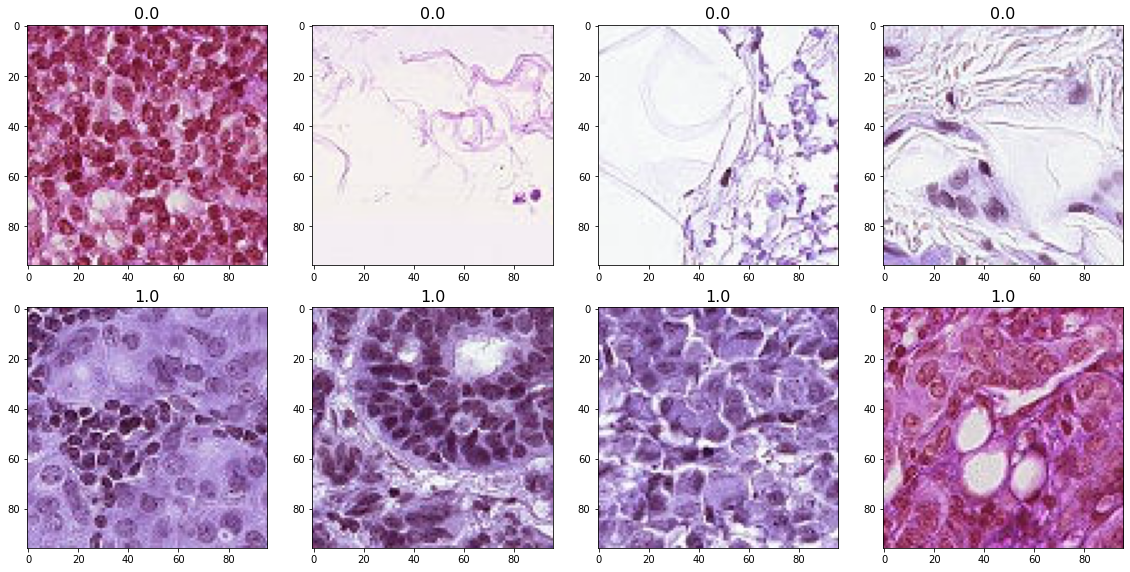

In [26]:
draw_category_images('label',4, df_data,'data/histopathologic-cancer-detection/train/')

Then create a training and and testing splits of the data in preperation for training

In [27]:
from sklearn.model_selection import train_test_split

y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train)
print(df_val)
print(y)

                                              id  label
134709  2ddb582347063e13f6e8e8bcc693c2ddc65f5781    0.0
122063  9563cbc9f43d2d2ecc1e8b757ee85637db430fe7    0.0
171972  2ca2f3a7c24ba5c5638089e1c08088ac246454fe    1.0
63378   ab452f00d0fc2a3dd7c4781c0dcaaecf4d71e4ab    1.0
36782   85aaec3a61c47e33d4bad167f9c1a013a2ff2401    0.0
...                                          ...    ...
117398  9e04c5701b81604b04bd340fb86f26c0ec0fa84d    0.0
87646   86611a3dae286bf57808cce6bd952777a83e2f98    0.0
99059   7344089a9732d851d3a5d41cf9c7849e53fc1e94    0.0
121588  a49c538708c85c9be22946c40e284d357bf960b5    0.0
21829   d7a3e35ffb2dfa20db4aff2c9e91edb64f4a369c    0.0

[198022 rows x 2 columns]
                                              id  label
79961   0d8c9abf388785a016d72e609ab932b7e134f827    0.0
45724   5566aa9c1d698535c449144d72e98556bf77fd47    0.0
81384   358c0ab1962f8f1c202b146d88b35f55252bde9f    1.0
91989   00f81cefedcc1fb79a5c500677aad14438c50296    0.0
177529  e7a806a270062

In [ ]:
import os
import shutil

base_dir = 'data/histopathologic-cancer-detection/split'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)

df_data_ind = df_data.set_index('id')

train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    
    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    

    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

### Model Architecture 

The first step of the model architecture is to use tensorflow's ImageDataGenerator tool to structure the data into files for easier modeling using and training.

In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_path = 'data/histopathologic-cancer-detection/split/train_dir'
valid_path = 'data/histopathologic-cancer-detection/split/val_dir'
test_path = 'data/histopathologic-cancer-detection/test'

img_size = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(rescale=1.0/255)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

I will then create a few callback functions that will stop training after if the training plateaus.

In [30]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
                              
                              
callbacks_list = [reducel, earlystopper]

In [31]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

Convolutional Neural Networks are the obvious choice for a problem of this type as we can use supervised learning and want to identify paterners in images that are not easily identified by human visuals.

To start I will create a CNN that relies on relu alforithms and filters that to help identify different features in the images. The dropout layers help limmit overfiting by limiting tensors from co-addaping too much.

In [ ]:

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [ ]:
model1.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath1 = "model.h5"

history1 = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

<Figure size 432x288 with 0 Axes>

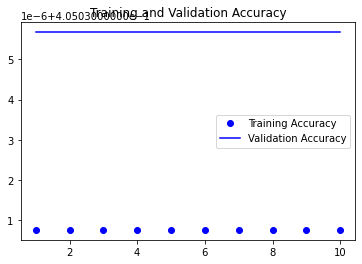

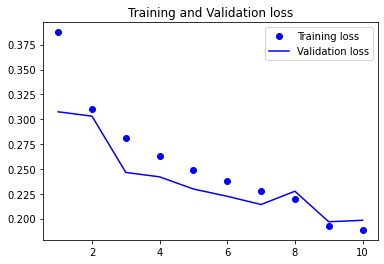

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

As we can see here while loss continues to go down the accurcy is very stagnate and has very poor validation accuracy.

In the second model, we add batch normaization which helps elimniate bias by reseting the mean and standard deviations. 

In [32]:

model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (img_size, img_size, 3)))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))


model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_6 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 46, 46, 32)       

In [33]:

model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
           
history2 = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
6189/6189 [==============================] - 4178s 675ms/step - loss: 0.4447 - accuracy: 0.7994 - val_loss: 0.8523 - val_accuracy: 0.6592 - lr: 1.0000e-04
Epoch 2/20
6189/6189 [==============================] - 4524s 731ms/step - loss: 0.3323 - accuracy: 0.8582 - val_loss: 0.6956 - val_accuracy: 0.7221 - lr: 1.0000e-04
Epoch 3/20
6189/6189 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.8780
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6189/6189 [==============================] - 4339s 701ms/step - loss: 0.2955 - accuracy: 0.8780 - val_loss: 0.7715 - val_accuracy: 0.7295 - lr: 1.0000e-04
Epoch 4/20
6189/6189 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8923
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch: 2.
6189/6189 [==============================] - 4452s 719ms/step - loss: 0.2656 - accuracy: 0.8923 - val_loss

<Figure size 432x288 with 0 Axes>

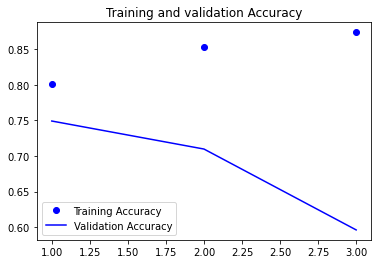

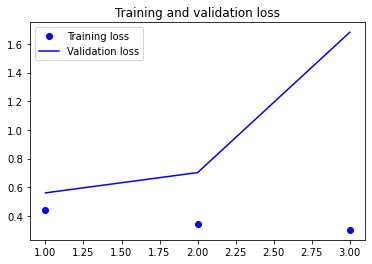

<Figure size 432x288 with 0 Axes>

In [ ]:

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()


plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

### Results and Analysis

While this is not the most encouraging resutls it is a marked improvement on the first model and gives arround a 75% accuracy. As I was training this I also started running into hardware limitations that were cauing training to take a long time. Since that is a limiting factor I will use this as my best result and resolve to use better hardware in future attemps of improvement.

### Conclusion

Below the file for the Kaggle results are published and I acheive a mark of 75.66% while this is below averge for this competitions due to hardwear issues durring the training process I will have to accept the results. The fact that the validation accuracy is declining at the end of the training is also worrying. 

In [83]:
test_dir = 'data/histopathologic-cancer-detection/test'
#os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [87]:
test_list = os.listdir('data/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    #shutil.copyfile(src, dst)

In [89]:
# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory('data/histopathologic-cancer-detection/test',
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [90]:
num_test_images = 57458
predictions = model2.predict(test_gen, steps = num_test_images, verbose=1)

57458/57458 [==============================] - 503s 9ms/step


In [98]:
df_preds = pd.DataFrame(predictions, columns=[ 'has_tumor_tissue'])

print(df_preds.head())

   has_tumor_tissue
0          0.295501
1          0.547640
2          0.160517
3          0.013173
4          0.003677


In [99]:


test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()


y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('preds.csv', columns=['label']) 

submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.295501
0000ec92553fda4ce39889f9226ace43cae3364e,0.547640
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.160517
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.013173
000270442cc15af719583a8172c87cd2bd9c7746,0.003677
